In [1]:
from data_generator import DataGenerator
from place_cells import PlaceCells

# cudnn.benchmark = True

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

options = AttrDict()

options.sequence_length = 100
options.periodic = False
options.batch_size = 228
options.box_width = 2.2
options.box_height = 2.2

pc = PlaceCells(n_P=10, func_type='DiffGaussTuningCurve', gpu=True)

dg = DataGenerator(options, pc, gpu=True)

# format: (inputs, place_outputs, pos)
inputs, place_outputs, pos = dg.get_test_batch()

In [2]:
init_pos = inputs[1].cpu().numpy()
velocity_signal = inputs[0].cpu().numpy()
pos = pos.cpu().numpy()
place_outputs = place_outputs.cpu().numpy()

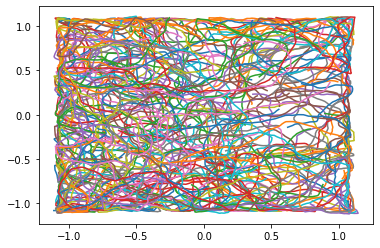

In [3]:
import matplotlib.pyplot as plt

for i in range(options.batch_size):
    plt.plot(pos[i,:,0], pos[i,:,1])
plt.show()

In [4]:
place_outputs.shape

(228, 100, 10)

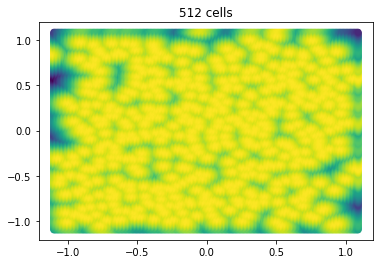

In [5]:
import numpy as np 
from torch import from_numpy

x = np.arange(-pc.L/2, pc.L/2, .01)
y = np.arange(-pc.L/2, pc.L/2, .01)
locations = np.array(np.meshgrid(x, y)).T.reshape((-1,2))

pc = PlaceCells(n_P=512, L=2, sigma_1=.2, sigma_2=.4, func_type='DiffGaussTuningCurve', gpu=True)
diff_resp = pc.encode_pos(from_numpy(locations).unsqueeze(0)).max(axis=-1).values.cpu().numpy()
# diff_resp = PC.get_responses(locations, func_type='DiffGaussTuningCurve')
h = plt.scatter(locations[:,0],locations[:,1], c=diff_resp.squeeze())
plt.title('512 cells')
plt.show()

In [20]:
from __future__ import division

from tfrecord.torch.dataset import TFRecordDataset
from model import VanillaRNN
from place_cells import PlaceCells
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scores
import utils
import matplotlib.pyplot as plt
import argparse
import os

WEIGHT_DECAY = 1e-5

L2 = False
SCHEDULE_LR = True 

if SCHEDULE_LR:
    from torch.optim.lr_scheduler import ReduceLROnPlateau



tfrecord_path = "rat2D_ns_2000000_sps_50.tfrecord"

npc = 512

t_place_cells = "DiffGaussTuningCurve"

nb_epoch = 1000

#torch.backends.cudnn.enabled = False  # memory leaks otherwise
gpu = False
if torch.cuda.is_available():  
  gpu = True

print('Using device:', 'gpu' if gpu else 'cpu')

def get_data_info(path):
  tmp = path.split('/')[-1].split('.')[0].split('_')
  return [int(tmp[2]),int(tmp[4])]

ns, sps = get_data_info(tfrecord_path)
batch_size = 200
init_pos_shape = (batch_size, 2)
velocities_shape = (batch_size, sps, 2)
target_pos_shape = (batch_size, sps, 2)
index_path = None
description = {"init_pos": "float", "velocities": "float", "target_positions": "float"}
dataset = TFRecordDataset(tfrecord_path, index_path, description, shuffle_queue_size=False)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=3)
 
if gpu:
  net = VanillaRNN(output_size=npc, hidden_size=npc).cuda()
else:
  net = VanillaRNN(output_size=npc, hidden_size=npc)

pc = PlaceCells(n_P=npc, func_type=t_place_cells, gpu=gpu)

optimizer =  optim.RMSprop(net.parameters(), lr=0.01, momentum=0.9)

if SCHEDULE_LR:
    scheduler = ReduceLROnPlateau(optimizer, 'min')

softmax = nn.Softmax(dim=-1).cuda()

def cross_entropy(preds, labels):
  return (-preds * softmax(labels)).sum(dim=-1).mean()

# criterion = nn.CrossEntropyLoss()   # nn.MSELoss()
##criterion = torch.nn.CrossEntropyLoss().cuda()
err_calc = torch.nn.MSELoss().cuda()
criterion = err_calc
starting_epoch = 0


model_directory = 'saved_models/tmp_mse_{}_model_{}_sps_{}_np_{}'.format('L2' if L2 else 'noL2', ns, sps, npc)
model_filename = 'latest.pt'
model_path = '/'.join([model_directory, model_filename])
plots_dir = '/'.join([model_directory, 'plots'])
losses_list_path = '/'.join([model_directory, 'losses.txt'])
test_losses_list_path = '/'.join([model_directory, 'test_losses.txt'])

# if model directory is not there create it 
if not os.path.isdir(model_directory):
  print("Creating directory for the model.")
  try:
    os.mkdir(model_directory)
  except OSError:
      print("Creation of the directory {} failed".format(model_directory))
  else:
      print("Successfully created the directory {} ".format(model_directory))

# if plots directory is not there create it 
if not os.path.isdir(plots_dir):
  print("Creating directory for the plots.")
  try:
    os.mkdir(plots_dir)
  except OSError:
      print("Creation of the directory {} failed".format(plots_dir))
  else:
      print("Successfully created the directory {} ".format(plots_dir))

if os.path.exists(model_path):
  print("Model checkpoint found directory for the model: {}".format(model_path))
  checkpoint = torch.load(model_path)
  net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  pc.c_i = checkpoint['pc_centers']
  epoch = checkpoint['epoch']+1
  loss = checkpoint['loss']
  print('Last checkpoint at {} epoch and {} loss'.format(epoch, loss))

# for plotter 
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
masks_parameters = zip(starts, ends.tolist())
scorer = scores.GridScorer(20, ((-110.0, 110.0), (-110.0, 110.0)), masks_parameters)

# To collect eval trajectories 
dataset = TFRecordDataset(tfrecord_path, index_path, description)
loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size))
eval_data = []
for _ in range(2):
  eval_data.append(next(loader))
    
net = net.eval()
xys = []
acts = []
test_loss = 0
cnt = 0 
for example in eval_data:
    i_pos = pc.encode_init_pos(example['init_pos'].cuda().view(*init_pos_shape))
    vel = example['velocities'].cuda().view(*velocities_shape)
    t_pos = example['target_positions'].cuda().view(*target_pos_shape)
    output, h_state, states = net(vel, i_pos)
    test_loss += err_calc(output, softmax(pc.encode_pos(t_pos)))
    cnt += 1
    xy = t_pos.to('cpu').detach().numpy().reshape(-1, t_pos.shape[-1])
    act = states.to('cpu').reshape(-1, states.shape[-1]).detach().numpy() # will work with multiple layers
    xys.append(xy)
    acts.append(act)
utils.append_losses(losses_list_path, [test_loss/cnt])
if SCHEDULE_LR:
    scheduler.step(test_loss/cnt)
xys = np.concatenate(xys, axis=0)
acts = np.concatenate(acts, axis=0)
_ = utils.get_scores_and_plot(scorer, xys, acts, plots_dir, 'activations_epoch_{}.pdf'.format(epoch))

ModuleNotFoundError: No module named 'model'

In [13]:
inputs, place_outputs, pos = dg.get_test_batch()

In [19]:
inputs[0].shape

torch.Size([228, 100, 2])